# Building Permit Metrics of San Francisco

This file takes Census Block Groups and (1) aggregates the permit and housing counts for the city of San Francisco from 2000 to 2019, and (2) collects demographic, built environment, & economic data. 

## Import Data

### Reference Data & Block Groups

In [81]:
## Packages & Paths

import geopandas as gpd
import pandas as pd
import numpy as np

import os 
os.chdir(r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics')

mile2feet = 5280
mi2ft = mile2feet 
feet2mile = 1/mile2feet
ft2mi = feet2mile

DATA_FOLDER = r'data'
META_FOLDER = DATA_FOLDER + r'\meta'
RAW_FOLDER = DATA_FOLDER + r'\raw'
CLEAN_FOLDER = DATA_FOLDER + r'\clean'

The reference data includes neighborhoods, quadrants, & block groups. I will be identify 4 block groups that are primarily non-residential and/or have special statuses preventing them from receiving permits. For example, the 'Presidio' area is run by the National Park Service and cannot receive development.

In [82]:
# NEIGHBORHOODS, QUADRANTS, & CENSUS BLOCKS

project_crs = 'EPSG:7132'
path = RAW_FOLDER + r'\georeference\sf_neighborhoods.geojson'
sfnhood = gpd.read_file(path).to_crs(project_crs)
project_crs = sfnhood.crs

path = RAW_FOLDER + r'\georeference\sf_quadrants.geojson'
sfquad = gpd.read_file(path).to_crs(project_crs)

path = CLEAN_FOLDER + r'\sf_2010censusblock.geojson'
sfblock = gpd.read_file(path).to_crs(project_crs)

sf_blockgroup = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)
non_res_geoid10 = [
    '06075060100', #presidio
    '06075980300', # golden gate park
    '06075980200', # land's end
    '06075060400', # Mercer Park
    '06075980501' # McLaren
]
sf_blockgroup_res = sf_blockgroup[~sf_blockgroup['geoid10'].isin(non_res_geoid10)]

sf_landform = sfblock.unary_union
sf_landform = gpd.GeoDataFrame(geometry=[sf_landform], crs=project_crs)
sf_landform_res = sf_blockgroup_res.unary_union
sf_landform_res = gpd.GeoDataFrame(geometry=[sf_landform_res], crs=project_crs)
sf_landform_nonres = gpd.overlay(sf_landform, sf_landform_res, how='symmetric_difference')

def geoid10_edit(n):
    g = str(n).zfill(11)
    return g

C:\Users\nelms\AppData\Local\Temp\ipykernel_25760\3622414581.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sf_blockgroup = sfblock.dissolve(by='geoid10').reset_index(drop=False).drop('block_id', 1)


### San Francisco Planning Permits 2000-2019

I initially was scraping the city's *Accela Permit Database API* for permits. Although this method gave me access to more information on permits from 2014-2019, I decided that it would be more valuable to focus on quantity rather than quality.

As a result, I found a pre-cleaned permit dataset from the SF Open Data Portal for ([2000-2013](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-before-January-1-2013/) and [2013-2019](https://data.sfgov.org/Housing-and-Buildings/Building-Permits-on-or-after-January-1-2013/)). Although there is less information on the permit's processing (e.g. permitting length), it provides me with an accurate history of development for 20 years.  The full list of permit fields can be found in [this spreadsheet](https://github.com/CPLN-680-Spring-2022/Nelms_Alex_BuildingPermits/blob/main/data/meta/sf_building_permit_fields.xlsx).

To prepare the permit dataset, I follow these steps: 
1. Filter by 'Project Profile' permits *(which are the 'main' permit)* & columns
2. Rename columns with metadata
3. Set integer & date type columns
4. Filter by permits with some form of proposed units
5. Remove Empty Geometry
6. Filter permits by:
    * A Start Date of 2000
    * A Close Date of 2019
7. Join to Neighborhoods

A permit has to start by January 1st 2000 and has to end by December 21st 2019. This will cause permits that are primarily in the process of permiting in 2000 & 2019 to be missing from the dataset. But I want to have a 2019 close date because I will not have to consider any effects due to COVID.

For my linear analysis, I will predicting for (1) counts of 2015-2019 permits *that construct a unit*, and (2) counts of 2015-2019 housing units. 

In [83]:
path = RAW_FOLDER + r'\sf_building_permits_20220411.csv'
sfb_full = pd.read_csv(path)

path = META_FOLDER + r'\sf_building_permit_fields.xlsx'
sfb_meta = pd.read_excel(path)
sfb_meta = sfb_meta.loc[sfb_meta['keep']=='y'].set_index('name')['new_name'].to_dict()

# # 1. FILTER BY PERMIT TYPE
# prj_filt = sfp_full['record_type']=='PRJ'
# sfp = sfp_full[prj_filt][keep_cols].copy()
# 
# # 2. RENAME COLUMNS
# sfp.columns = [
#     new_col_names[c] if c in new_col_names.keys()
#     else c
#     for c in list(sfp)
# ]
# 
# # 3. SET DATA TYPES
# ## INTEGERS
# unit_col = [c for c in list(sfp) if '#' in c]
# sfp[unit_col] = sfp[unit_col].astype(float).astype(int)
# ## DATES
# date_col = [c for c in list(sfp) if 'date' in c]
# sfp[date_col] = sfp[date_col].apply(pd.to_datetime)
# 
# # 4. FILTER BY UNITS
# all_filt = sfp['#units_prop']>0
# mr_filt = sfp['#units_prop_mr']>0
# sfp = sfp[all_filt|mr_filt]
# 
# # 5. REMOVE EMPTY GEOMETRY
# sfp = sfp[~sfp['geometry'].is_empty] 
# sfp_all = sfp.copy()
# 
# # 6. SET DATES 
# ## OPEN DATE OF 2000
# date_open = '2000-01-01'
# open_filt = sfp['date_open']>date_open
# ## CLOSE DATE OF late 2019
# date_close = '2019-31-01'
# close_filt = sfp['date_close'].dt.to_period("Q")>=date_close
# sfp = sfp[open_filt&close_filt]
# 
# # 7. JOIN TO NEIGHBORHOODS
# sfp = sfp.sjoin(sfnhood).drop(columns='index_right')


#for c in sfb_meta.keys(): 
#    if c not in list(sfb_full):
#        print(c)

sfb_full = sfb_full[sfb_meta.keys()].rename(columns=sfb_meta).sort_values('date_issued')
for c in [c for c in sfb_meta.values() if 'date' in c]:
    sfb_full[c] = pd.to_datetime(sfb_full[c])

wgs84_crs = "epsg:4326"

sfbg = sfb_full[['pid', 'rid', 'geometry']]
sfbg = gpd.GeoDataFrame(sfbg, geometry=gpd.GeoSeries.from_wkt(sfbg['geometry']), crs=wgs84_crs).to_crs(project_crs)
sfbg = gpd.overlay(sfbg, sf_blockgroup, how='intersection')
sfbg.head()

sfb_full = sfb_full.set_index(['pid','rid']).join(sfbg[[c for c in list(sfbg) if c != 'geometry']].set_index(['pid','rid'])).reset_index(drop=False)

date_col = 'date_issued'
year_bins = ['2000', '2005', '2010', '2015', '2020'] 
year_bins = pd.to_datetime(year_bins)
year_labels = ['00-04', '05-09', '10-14', '15-19']
sfb_full['5years'] = pd.cut(sfb_full[date_col], year_bins, labels=year_labels, include_lowest=True)

date_col = '5years'
sfbb = sfb_full.groupby(['geoid10', date_col]).agg({
    'units_prop':'sum', 'rid':'count'
    }).reset_index(drop=False)
sfbb = sfblock.set_index('geoid10').join(sfbb.set_index('geoid10')).rename(columns={
    'units_prop':'units.tot',
    'rid':'permits.tot'
})
sfbb_j = sfbb[[c for c in list(sfbb) if c not in ['block_id', 'geometry']]] \
    .reset_index() \
    .set_index(['geoid10', '5years']) \
    .dropna()

per_types = ['units.tot', 'permits.tot']
sfbb_jp = sfbb_j.reset_index(drop=False).pivot(
    index='geoid10',
    columns='5years',
    values=per_types
)
sfbb_jp.columns = [
    t + '.' + y.replace('-','_') for t,y in sfbb_jp.columns
    ]

keep_years = []
for search_yrs in [['00_04', '05_09', '10_14']]:
    evicts10_19 = [c for c in list(sfbb_jp) if any(yrs for yrs in search_yrs if yrs in c)]
    for start in range(0,len(evicts10_19), len(search_yrs)):
        cols = evicts10_19[start:start+len(search_yrs)]
        typ = cols[0].split('.')[0]
        focus_years = search_yrs[0][0:2] + '_' + search_yrs[-1][-2:]
        focus_cols = typ+'.tot.{}'.format(
            focus_years
        )
        sfbb_jp[focus_cols] = sfbb_jp[cols].sum(axis=1)
        keep_years.append(focus_cols)

miss_geos = list(sfbb_jp.index) + [i for i in sf_blockgroup['geoid10'].unique() if i not in sfbb_jp.index]

sfbb_jp = sfbb_jp.reindex(miss_geos,fill_value=0)

c:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


### SF Eviction Data 2000-19

One point to focus on is how many people were forceable remove from areas in San Francisco. The data comes from [SF's Open Data portal](https://data.sfgov.org/Housing-and-Buildings/Eviction-Notices/5cei-gny5). The dataset provides a variety of reasons for eviction but I aggregated them into categories:
* Renter Breached Lease - *e.g. illegal roommate*
* Owner Changed Housing Use - *e.g. Condo Conversion*
* Major Renovations
* Failure of Renter Payment
* Total Evictions

In [84]:
#path = RAW_FOLDER + r'\sf_holc1937_districts.geojson'
#sfholc = gpd.read_file(path).to_crs(project_crs)
#sfholc = sfholc[['holc_grade', 'geometry']]
#sfholc.plot(column='holc_grade')

# RENAME & META DF
path = META_FOLDER + r'\sf_evict_fields.xlsx'
sfevict_meta = pd.read_excel(path)
sfevict_rename = sfevict_meta[sfevict_meta['keep']=='y'].set_index('name')['new'].to_dict()
sfevict_counts = sfevict_meta[sfevict_meta['evict_num']=='y']
# GROUP COUNTS
sfevict_groups = sfevict_counts.groupby('evict_group').agg({'new':list})['new'].to_dict()
sfevict_counts = list(sfevict_counts['new'].unique())

# IMPORT & RENAME
path = RAW_FOLDER + r'\evict\sf_evict_20220413.csv'
sfevict = pd.read_csv(path)
sfevict = sfevict[sfevict_rename.keys()].rename(columns=sfevict_rename)
sfevict[sfevict_counts] = sfevict[sfevict_counts].replace(True, 1).replace(False,0)
# COUNT FIELDS
for grouper, group_list in sfevict_groups.items():
    sfevict[grouper] = sfevict[group_list].sum(axis=1)
sfevict['tot_evictions'] = 1
count_cols = list(sfevict_groups.keys()) + ['tot_evictions']
# GET GEOM PTS
sfevict = sfevict[sfevict['shape'].apply(type)==str]
sfevict['geometry'] = gpd.GeoSeries.from_wkt(sfevict['shape'])
sfevict = gpd.GeoDataFrame(sfevict, crs=wgs84_crs).to_crs(project_crs)
# FILTER
sfblock_filter = gpd.GeoDataFrame(geometry=sf_landform.buffer(.1 * mile2feet), crs=project_crs)
sfevict = gpd.overlay(
    sfevict,
    sfblock_filter,
    how='intersection'
    )
sfevict = gpd.sjoin_nearest(
    sfevict, sf_blockgroup_res, how='inner', max_distance=1000 
)

# DATE
date_col = 'file_date'
sfevict[date_col] = pd.to_datetime(sfevict[date_col])
year_bins = ['2000', '2005', '2010', '2015', '2020'] 
year_bins = pd.to_datetime(year_bins)
year_labels = ['00-04', '05-09', '10-14', '15-19']
sfevict['5years'] = pd.cut(sfevict[date_col], year_bins, labels=year_labels, include_lowest=True)

# group_by year & GEOID
agg_cols = {c:sum for c in count_cols}
sfevict = sfevict.groupby(['geoid10', '5years']).agg(agg_cols)

# AGGREGATE BY EVICTION TYPE
evict_types = ['breach_lease', 'change_use', 'reno', 'renter_payment', 'tot_evictions']
c = evict_types[0]
sfevict_p = sfevict.reset_index(drop=False).pivot(
    index='geoid10',
    columns='5years',
    values=evict_types
)
sfevict_p.columns = [
    t.replace('tot_','') + '.tot.' + y.replace('-','_') for t,y in sfevict_p.columns
    ]
keep_years = []
for search_yrs in [['10_14','15_19'], ['00_04', '05_09', '10_14','15_19']]:
    evicts10_19 = [c for c in list(sfevict_p) if any(yrs for yrs in search_yrs if yrs in c)]
    for start in range(0,len(evicts10_19), len(search_yrs)):
        cols = evicts10_19[start:start+len(search_yrs)]
        typ = cols[0].split('.')[0]
        focus_years = search_yrs[0][0:2] + '_' + search_yrs[-1][-2:]
        focus_cols = typ+'.tot.{}'.format(
            focus_years
        )
        if (focus_years == '00_19')and(typ!='evictions'):
            pass
        else:
            sfevict_p[focus_cols] = sfevict_p[cols].sum(axis=1)
            keep_years.append(focus_cols)
sfevict_p = sfevict_p[keep_years]

miss_geos = list(sfevict_p.index) + [i for i in sf_blockgroup['geoid10'].unique() if i not in sfevict_p.index]

sfevict_p = sfevict_p.reindex(miss_geos,fill_value=0)

### Demographic & Rent Change (2000-15)

This demographic data was pre-cleaned by the Urban Displacement Project in order to create a variety of their data and reports [[Github](https://github.com/urban-displacement/displacement-typologies)] . This specific dataset of theirs was scraped from this [Web Map](https://www.urbandisplacement.org/maps/sf-bay-area-rent-and-demographic-change/) and displays a variety of changes from 2000 to 2015:
* Median Rent
* Income Percentages
* Racial Percentages

In [85]:
path = RAW_FOLDER + r'\bayarea_demodata_censusblock.json'
sfdemo = gpd.read_file(path, crs=wgs84_crs).to_crs(project_crs)
# FILTER BY FIPS
sfdemo['geoid10'] = sfdemo['geo_fips'].apply(geoid10_edit)
sfdemo = sfdemo[sfdemo['geoid10'].str[0:5] == '06075']
# FILTER BY GEO
sfdemo = gpd.overlay(sfdemo, sf_landform, how='intersection')
# FORMAT COLUMNS
admin_col = ['_tract','fips','geo_fips','field_1', 'geoid10', 'geometry']
sfdemo[[c for c in list(sfdemo) if c not in admin_col]] = sfdemo[[c for c in list(sfdemo) if c not in admin_col]].astype(float)

sfdemo['geoid10'] = sfdemo['geo_fips'].apply(geoid10_edit)
sfdemo['poc_linc.pct.10_15'] = sfdemo['lw_poc']
#sfdemo['blk_linc.pct.10_15'] = sfdemo['lw_blk']
sfdemo['wht.pct.10_15'] = sfdemo['all_wht']
sfdemo.loc[sfdemo['poc_linc.pct.10_15']<-8000, 'poc_linc.pct.10_15'] = -1000
sfdemo.loc[sfdemo['wht.pct.10_15']<-8000, 'wht.pct.10_15'] = -1000
sfdemo = sfdemo.set_index('geoid10')[[c for c in list(sfdemo) if ('.10_15' in c) or c == 'geometry']]

# all    All
# asn    Asian
# blk    Black
# hsp    Latinx
# poc    All People of Color
# wht    White

# all    All
# h    High [>120% AMI]
# m    Middle [80%-120% AMI]
# lw    Low [<80% AMI]
# vl    Very Low [<50% AMI]
# el    Extremely Low [<30% AMI]

#path = RAW_FOLDER + r'\bayarea_rentdata_censusblock.json'
#sfrent = gpd.read_file(path, crs=wgs84_crs).to_crs(project_crs)

#sfrent = gpd.overlay(
#    sfrent,
#    sf_landform,
#    how='intersection'
#    )

### Displacement Metrics (1990-2018)

Like the previous dataset, this is from the Urban Displacement Project [[Github](https://github.com/urban-displacement/displacement-typologies)] but is a larger collection of metrics *(about 360 fields)* from Zillow, ACS, Census, and the UCLA vulnerability indicators. The full list of potential metrics can be found in [this spreadsheet](https://github.com/CPLN-680-Spring-2022/Nelms_Alex_BuildingPermits/blob/main/data/meta/sf_displace_fields.xlsx).

I will only bring in 45 metrics into Sections 2 & 3 of my report to potentially use for a linear model. The main metrics I look at include:
* Home Values
* Percent of Owner Occupied Units
* Recently Moved People
* Percent with a college degree
* Low Income Households

for the years of 1990, 2000, 2010, & 2018. 

In [86]:
path = META_FOLDER + r'\sf_displace_fields.xlsx'
sfdis_meta = pd.read_excel(path)
sfdis_rename = sfdis_meta[sfdis_meta['keep']=='y'].set_index('name')['new'].to_dict()
sfdis_rename['geometry'] = 'geometry'
#sfdis_counts = sfdis_meta[sfdis_meta['evict_num']=='y']
# GROUP COUNTS
#sfdis_groups = sfdis_counts.groupby('evict_group').agg({'new':list})['new'].to_dict()
#sfdis_counts = list(sfdis_counts['new'].unique())

path = RAW_FOLDER + r'\displacement-typologies\sf_displace_db_2018.csv'
sfdis = pd.read_csv(path)
sfdis = sfdis[list(sfdis_rename.keys())].rename(columns=sfdis_rename)
# FILTER BY CA & SF FIPS CODES 
sfdis['geoid10'] = sfdis['geoid10'].apply(geoid10_edit)
sfdis = sfdis[sfdis['geoid10'].str[0:5] == '06075']

float_cols = [c for c in list(sfdis) if c not in ['geometry', 'geoid10']]
sfdis[float_cols] = sfdis[float_cols].astype(float)
sfdis = gpd.GeoDataFrame(sfdis, geometry=gpd.GeoSeries.from_wkt(sfdis['geometry']), crs=wgs84_crs).to_crs(project_crs)
# GEO FILTER
sfdis = gpd.overlay(
    sfdis,
    sf_landform,
    how='intersection'
    )

mov_12 = [c for c in list(sfdis) if any(t for t in ['own','rent'] if 'occ_'+t+'.' in c) and any(y for y in ['00','90'] if y in c)]

for y in ['90', '00', '18']:
    own_col = 'occ_own.tot.{}'.format(y)
    rent_col = 'occ_rent.tot.{}'.format(y)
    sfdis['occ_own.pct.{}'.format(y)] = (sfdis[own_col]/(sfdis[own_col]+sfdis[rent_col]))*100
    sfdis['occ_rent.pct.{}'.format(y)] = (sfdis[rent_col]/(sfdis[own_col]+sfdis[rent_col]))*100

for y in ['90', '00']:
    for t in ['rent', 'own']:
        typ_col = 'occ_{}.pct.{}'.format(t, y)
        sfdis['occ_{}_ch.pct.{}_18'.format(t,y)] = (sfdis['occ_{}.pct.18'.format(t)] - sfdis[typ_col])/sfdis[typ_col]
sfdis = sfdis[[c for c in list(sfdis) if c not in mov_12]].set_index('geoid10')

### SF Parcels & Land Use (2022)

One major consideration is how the current built environment & land use affects where housing is built. The main dataset I am looking at is 2022 parcels from ([from SF Open Data](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Parcels-Active-and-Retired/acdm-wktn)).

Even though this parcel dataset is from 2022, I am not worried that there was a big enough change in the built environment between 2015 to 2022 to truly affect a generalized analysis. Designation & parcel changes typically happen on a per-parcel basis slowly over time. Large changes usually only happen during large specific plans ever 10 years, and don't change land uses dramatically. If a block group has 80% of its area zoned for residential, it would be extremeley unlikely for there to be a land use designation change greater than 20% in that period. This estimation comes from my 4+ years of professional experience in managing parcels and land use change at a city planning department level in the Bay Area.

For this dataset, I will be looking at:
* housing units counts
* units per parcel
* area that is zoned for residential
* building square footage
* floor ratio area

In [87]:
path = RAW_FOLDER + r'\sf_parcels_20220414.geojson'
sfpar = gpd.read_file(path).to_crs(project_crs)
sfpar.head()
# GET AREA
sfpar['bldgsqft'] = sfpar['bldgsqft'].astype(float)
sfpar['lotarea'] = sfpar.area
sfpar['lotarea_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'lotarea_res'] = sfpar['lotarea_res'] + sfpar['lotarea']
sfpar.loc[sfpar['landuse']=='MIXRES', 'lotarea_res'] = sfpar['lotarea_res'] + sfpar['lotarea']/2
# GET RESI BSQFT
sfpar['bsqft_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'bsqft_res'] = sfpar['bsqft_res'] + sfpar['bldgsqft'].astype(float)
sfpar.loc[sfpar['landuse']=='MIXRES', 'bsqft_res'] = sfpar['bsqft_res'] + sfpar['bldgsqft'].astype(float)/2
# FAR
sfpar['FAR'] = sfpar['bldgsqft'].astype(float) / sfpar['lotarea']
# counts
sfpar['parcels'] = 1
sfpar['parcels_res'] = 0
sfpar.loc[sfpar['landuse']=='RESIDENT', 'parcels_res'] = 1
sfpar.loc[sfpar['landuse']=='MIXRES', 'parcels_res'] = .5

sfpar['yrbuilt'] = sfpar['yrbuilt'].astype(int)
sfpar['resunits'] = sfpar['resunits'].astype(int)
sfpar['ID'] = 'P' + sfpar.index.astype(str).str.zfill(5)

# sjoin to get geoid10 to tracts
sfpar_c = sfpar[['ID', 'geometry']].copy()
sfpar_c['geometry'] = sfpar_c['geometry'].centroid
sfpar_cj = sfpar_c.sjoin_nearest(sf_blockgroup, how='inner', max_distance=1000)
sfpar = sfpar.set_index('ID').join(sfpar_cj[['ID', 'geoid10']].set_index('ID'), how='inner').reset_index()

par_calc = {
    'parcels':'sum',
    'parcels_res':'sum',
    'resunits':['sum','mean'],
    #'yrbuilt':'mean',
    'lotarea':['mean', 'sum'],
    'lotarea_res':'sum',
    'bldgsqft': ['mean', 'sum'],
    'bsqft_res':'sum',
    'FAR':'mean'
}
sfpar_g = sfpar.groupby('geoid10').agg(par_calc)
sfpar_g.columns = [
    '.'.join(list(c)).replace('mean','avg').replace('sum','tot').replace('resunits','units')
    for c in sfpar_g.columns]
sfpar_g['area_res.pct'] = (sfpar_g['lotarea_res.tot']/sfpar_g['lotarea.tot'])*100
sfpar_g['bsqft_res.pct'] =(sfpar_g['bsqft_res.tot']/sfpar_g['bldgsqft.tot'])*100
sfpar_g['units_p_parcel.avg'] = sfpar_g['units.tot'] / sfpar_g['parcels.tot']
sfpar_g['units_p_parcel_r.avg'] = sfpar_g['units.tot'] / sfpar_g['parcels_res.tot']
#sfpar_g['FAR.avg'] = sfpar_g['FAR.avg'].round(3)
keep = [
    'units.tot', 'units.avg', 'lotarea.avg', 'area_res.pct', 
    'bldgsqft.avg', 'bldgsqft.tot', 'FAR.avg','bsqft_res.pct',
    'lotarea_res.tot', 'units_p_parcel.avg', 'units_p_parcel_r.avg'
    ]
sfpar_g = sfpar_g[keep]
sfpar_g.columns = [c+'.2019' for c in sfpar_g.columns]
sfpar_g.head()

,units.tot.2019,units.avg.2019,lotarea.avg.2019,area_res.pct.2019,bldgsqft.avg.2019,bldgsqft.tot.2019,FAR.avg.2019,bsqft_res.pct.2019,lotarea_res.tot.2019,units_p_parcel.avg.2019,units_p_parcel_r.avg.2019
geoid10,,,,,,,,,,,
06075010100,2040,6.822742,22938.936896,12.353176,14647.043478,4379466.0,1.252450,18.868647,8.472725e+05,6.822742,14.315789
06075010200,3323,5.241325,7937.412611,36.436412,5047.370662,3200033.0,1.262131,66.351316,1.833597e+06,5.241325,7.055202
06075010300,2274,3.900515,3166.779919,71.265029,4029.675815,2349301.0,1.491761,77.922944,1.315718e+06,3.900515,4.722741
06075010400,2702,3.612299,3212.946873,61.179392,3718.394385,2781359.0,1.437555,70.805135,1.470315e+06,3.612299,4.690972
06075010500,1957,12.875000,32918.975413,15.446924,55448.861842,8428227.0,1.930136,8.460433,7.729153e+05,12.875000,170.173913


### Combine

Bringing the Permits, Evictions, Demographic, Economic, Parcel, & Land-Use data all into one dataframe for export & visualizations

In [88]:
join_dfs = [
    sfbb_jp,
    sfevict_p,
    sfdemo[[c for c in list(sfdemo) if c not in ['binned', 'geometry']]],
    sfdis[[c for c in list(sfdis) if c!='geometry']],
    sfpar_g
    ]
main_df = sf_blockgroup.set_index('geoid10').copy()
for join_df in join_dfs:
    main_df = main_df.join(join_df)

sqft2sqmi = 0.00000003587006428
main_df.loc[main_df["area_res.pct.2019"]<=0, "area_res.pct.2019"] = .0000001
main_df["area"] = main_df.geometry.area * sqft2sqmi
main_df["res_area"] = main_df["area_res.pct.2019"] * main_df["area"]
main_df["pop_dens.tot.2018"] = round(main_df['pop.tot.18'] / main_df["area"])
main_df["pop_dens_res.tot.2018"] = round(main_df['pop.tot.18'] / main_df["res_area"])
main_df.loc[(main_df['pop.tot.18']<100), "pop_dens_res.tot.2018"] = 0

inf_90_to_18 = 1.92
inf_00_to_18 = 1.46
main_df['hh_inc.med.90'] = main_df['hh_inc.med.90'] * inf_90_to_18
main_df['hh_inc.med.00'] = main_df['hh_inc.med.00'] * inf_00_to_18

main_df['hh_inc_ch.med.90_18'] = (main_df['hh_inc.med.18'] - main_df['hh_inc.med.90']) / main_df['hh_inc.med.18']

from datetime import datetime
todays_date = datetime.today().strftime('%Y%m%d')
path = r'data\clean' + '\sf_dataset_{}.geojson'.format(todays_date)
main_df.to_file(path)

In [89]:
import geopandas as gpd
INITIAL_DIR = r'C:\Users\nelms\Documents\Penn\CPLN-680\Permit_Metrics\\'
NEW_DIR = r'C:\Users\nelms\Documents\Penn\MUSA-611\sf-building-permits-web-map\\'

path = INITIAL_DIR + r'data\clean\sf_dataset_20220415.geojson'
#main_df = gpd.read_file(path)

In [90]:
path = NEW_DIR + r'data\sf_permit_metrics.geojson'
web_crs = 'EPSG:4326'
#main_df.to_crs(web_crs).to_file(path)

path = INITIAL_DIR + r'data\raw\georeference\sf_neighborhoods.geojson'
#sfnhood = gpd.read_file(path)

path = NEW_DIR + r'data\sf_neighborhoods.geojson'
#sfnhood.to_crs(web_crs).to_file(path)

## EXPLORATORY DATA ANALYSIS

<AxesSubplot:xlabel='date_issued'>

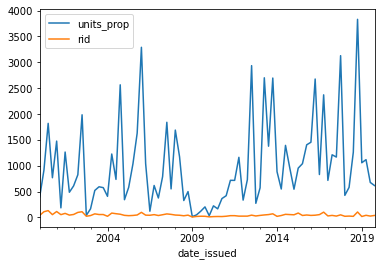

In [91]:
sfbb = sfb_full.copy()
date_col = 'date_issued'
period = 'Q'
sfbb[date_col] = sfbb[date_col].dt.to_period(period)
sfbb = sfbb.groupby(date_col).agg({
    'units_prop':'sum', 
    'rid':'count'
    })
sfbb.plot()

#sfb_full.groupby(focus_col).agg({
#    'units_prop':'sum', 'rid':'count'
#})['rid'].plot.bar()

In [92]:
def plot_labels(focus_gdf, label_col, ax, zorder=8):
    xylabel = zip(focus_gdf.geometry.centroid.x, focus_gdf.geometry.centroid.y, focus_gdf[label_col])
    for x, y, label in xylabel:
        ax.annotate(
            label, xy=(x, y), 
            fontsize='large',
            fontweight='bold',
            zorder=zorder
            )
def plot_quads(ax, zorder=8):
    plot_labels(sfquad, 'quad', ax, zorder=zorder)

def get_cmap(data_list, cmap, grey_bottom=True, skip_1=False):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce = -1
    if skip_1 == True:
        reduce = 1
    cmap = get_colors(len(data_list)+reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    if skip_1 == True:
        cmap = cmap[1:]
    return {v:c for v,c  in zip(data_list, cmap)}

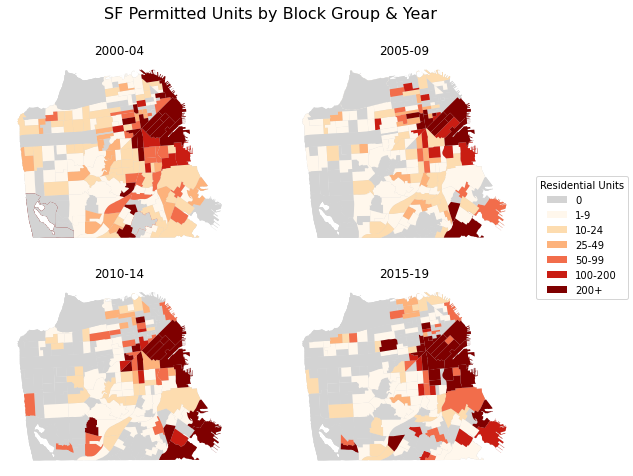

In [93]:
import matplotlib.pyplot as plt

nrows, ncols = (2,2)
fig, axes = plt.subplots(nrows,ncols)

date_col = '5years'
sfbb = sfb_full.groupby(['geoid10', date_col]).agg({
    'units_prop':'sum', 'rid':'count'
    }).reset_index(drop=False)
sfbb = sfblock.set_index('geoid10').join(sfbb.set_index('geoid10'))

focus_col = 'unit_bins'
date_col = '5years'

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(sfbb[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='units_prop'
data_bins = [0,1,10,25,50,100,200,max(sfbb[focus_col])]
data_labels = ['0','1-9','10-24','25-49', '50-99', '100-200', '200+']
sfbb['unit_bins'] = get_bins(sfbb, focus_col, data_bins, data_labels)

cmap = get_cmap(data_labels, 'OrRd')

focus_col = 'unit_bins'

year_bins = list(sfb_full[date_col].unique())
year_bins.sort()
year_bins = np.array(year_bins).reshape(nrows, ncols)

for row in range(nrows):
    for col in range(ncols):
        year = year_bins[row,col]
        ax = axes[row,col]
        sfbb_sub = sfbb[
            (sfbb[date_col]==year)&(sfbb[focus_col]!=0)
        ]
        for value,color in cmap.items():
            sfbb_sub[sfbb_sub[focus_col]==value].plot(
                ax=ax,
                zorder=5, legend=True,
                color = color
            )
        sfblock.plot(
            
            ax=ax, zorder=4,
            color='lightgrey'
            )
        #plot_quads(ax)
        sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

        ax.set_title('20'+str(year))
        ax.set_axis_off()

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
fig.legend(handles = handles, labels=labels,
       loc="center right", 
       title="Residential Units"
       #borderaxespad=0.1
       )
plt.subplots_adjust(right=0.85)

fig.suptitle('SF Permitted Units by Block Group & Year', fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)
#fig.tight_layout()

c:\ProgramData\Miniconda3\envs\permit_metrics\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


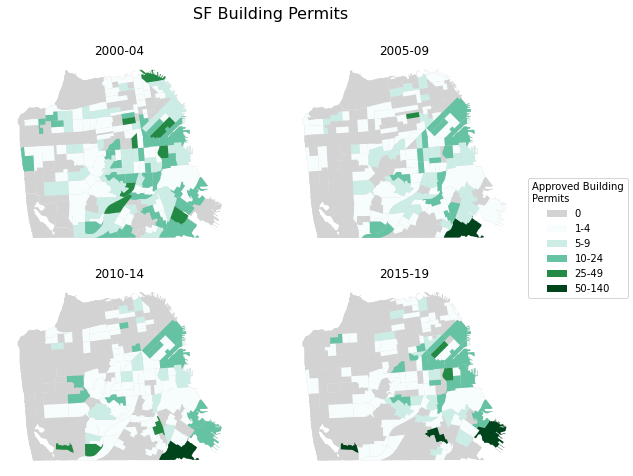

In [94]:
import matplotlib.pyplot as plt

nrows, ncols = (2,2)
fig, axes = plt.subplots(nrows,ncols)

date_col = '5years'
sfbb = sfb_full.groupby(['geoid10', date_col]).agg({
    'units_prop':'sum', 'rid':'count'
    }).reset_index(drop=False)
sfbb = sfblock.set_index('geoid10').join(sfbb.set_index('geoid10'))

focus_col = 'unit_bins'
date_col = '5years'

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(sfbb[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='rid'
data_bins = [0,1,5,10,25,50,max(sfbb[focus_col])]
data_labels = ['0','1-4', '5-9','10-24','25-49', '50-140']
sfbb['unit_bins'] = get_bins(sfbb, focus_col, data_bins, data_labels)

cmap = get_cmap(data_labels, 'BuGn')

focus_col = 'unit_bins'

year_bins = list(sfb_full[date_col].unique())
year_bins.sort()
year_bins = np.array(year_bins).reshape(nrows, ncols)

for row in range(nrows):
    for col in range(ncols):
        year = year_bins[row,col]
        ax = axes[row,col]
        sfbb_sub = sfbb[
            (sfbb[date_col]==year)&(sfbb[focus_col]!=0)
        ]
        for value,color in cmap.items():
            sfbb_sub[sfbb_sub[focus_col]==value].plot(
                ax=ax,
                zorder=5, legend=True,
                color = color
            )
        sfblock.plot(
            ax=ax, zorder=4,
            color='lightgrey'
            )
        #plot_quads(ax)
        sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

        ax.set_title('20'+str(year))
        ax.set_axis_off()

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
fig.legend(handles = handles, labels=labels,
       loc="center right", 
       title="Approved Building\nPermits"
       #borderaxespad=0.1
       )
plt.subplots_adjust(right=0.85)

fig.suptitle('SF Building Permits', fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)
#fig.tight_layout()

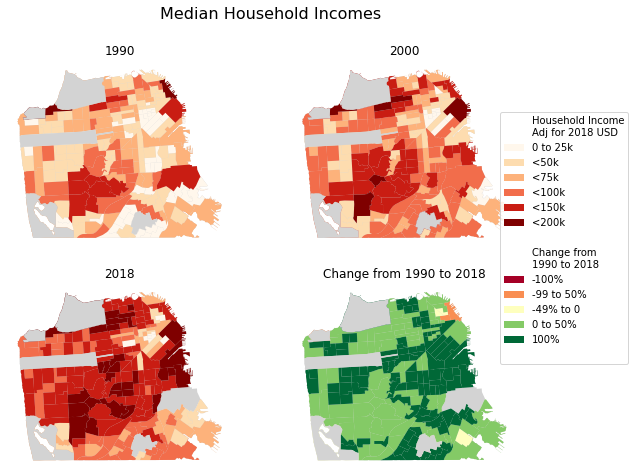

In [113]:

focus_gdf = main_df
focus_cols = [
    'hh_inc.med.90',
    'hh_inc.med.00',
    'hh_inc.med.18',
    'hh_inc_ch.med.90_18'
]
focus_gdf = focus_gdf[focus_cols+['geometry']].copy()
focus_labels = [
    '1990', '2000', '2018', 'Change from 1990 to 2018'
]
plot_title = 'Median Household Incomes'

focus_styles = [0,0,0,1]

bin_dicts = {
    0:[0, 25000, 50000, 75000, 100000, 150000, 200000],
    1:[-10,-1,-.5,0,.5,1]
}
label_dicts = {
    0:['0 to 25k', '<50k', '<75k', '<100k', '<150k', '<200k'],
    1:['-100%','-99 to 50%','-49% to 0','0 to 50%', '100%']
}
cmap_dicts = {
    0:'OrRd', 
    1:'RdYlGn'
}
legend_labels = {
    0:'Household Income\nAdj for 2018 USD',
    1:'Change from\n1990 to 2018'
}
cmap_dicts = {
    style_index:
        get_cmap(label_dicts[style_index], cmap, grey_bottom=False) if any(lab for lab in label_dicts[style_index] if '%' in lab)
        else get_cmap(label_dicts[style_index], cmap, grey_bottom=False)
    for style_index,cmap in cmap_dicts.items()
}

### plotting

nrows, ncols = (int(len(focus_styles)/2), 2)
fig, ax = plt.subplots(int(nrows),int(ncols))
axes = []
[[axes.append([row, col]) for col in range(ncols)] for row in range(nrows)]

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], bins, labels=labels, include_lowest=True)

def bin_col(focus_df, focus_col, data_bins, data_labels):
    pot_max = max(focus_df[focus_col])
    if pot_max > data_bins[-1]:
        data_bins = data_bins[:-1] + [max(focus_df[focus_col])]
    return get_bins(focus_df, focus_col, data_bins, data_labels)

for e, focus_col in enumerate(focus_cols):
    row,col = axes[e]
    axis = ax[row,col]

    style_index = focus_styles[e]
    focus_col, focus_title = focus_cols[e], focus_labels[e]

    data_bin, data_label = bin_dicts[style_index], label_dicts[style_index]
    cmap = cmap_dicts[style_index]
    focus_gdf['bin_col'] = bin_col(focus_gdf, focus_col, data_bin, data_label)
    
    for value,color in cmap.items():
        temp_gdf = focus_gdf[focus_gdf['bin_col']==value]
        if len(temp_gdf) > 0:
            temp_gdf.plot(
                ax=axis,
                zorder=5, legend=True,
                color = color
            )
    sfblock.plot(
                ax=axis, zorder=4,
                color='lightgrey'
                )
    #plot_quads(ax)
    sf_landform_nonres.plot(ax=axis, color='lightgrey', zorder=8)
    axis.set_title(focus_title)
    axis.set_axis_off()

import matplotlib.patches as mpatches
handles = []
labels = []
for style_index in set(focus_styles):
    cmap = cmap_dicts[style_index]
    labs = [legend_labels[style_index]] + list(cmap.keys()) + ['    ']
    labels.extend(labs)
    colors = ['#FFFFFF'] + list(cmap.values()) + ['#FFFFFF'] 
    handles.extend([mpatches.Patch(facecolor=color) for color in colors]) #mpatches.Patch(facecolor='r', edgecolor='#000000')

fig.legend(handles = handles, labels=labels,
        loc="center right", 
        #title="Approved Building\nPermits"
        #borderaxespad=0.1
        )
plt.subplots_adjust(right=0.85)
fig.suptitle(plot_title, fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)

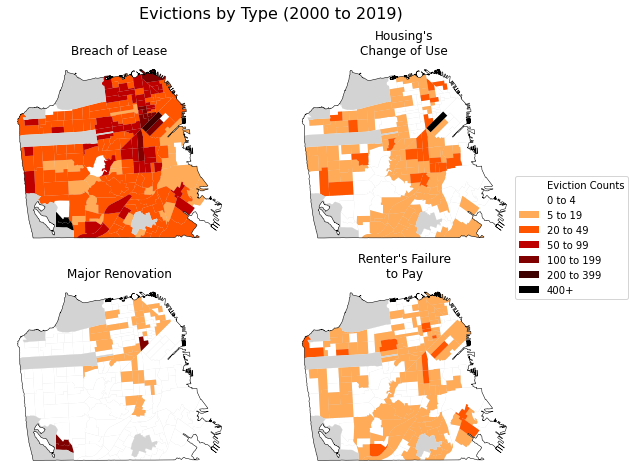

In [101]:

focus_gdf = main_df
focus_cols = [
    'breach_lease.tot.10_19',
 'change_use.tot.10_19',
 'reno.tot.10_19',
 'renter_payment.tot.10_19',
]
focus_gdf = focus_gdf[focus_cols+['geometry']].copy()
focus_labels = [
    'Breach of Lease', "Housing's\nChange of Use", 'Major Renovation', "Renter's Failure\nto Pay"
]
plot_title = 'Evictions by Type (2000 to 2019)'

focus_styles = [0,0,0,0]

bin_dicts = {
    0:[0, 5, 20, 50, 100, 200, 400, 1000],
    1:[-10,-1,-.5,0,.5,1]
}
label_dicts = {
    0:['0 to 4', '5 to 19', '20 to 49', '50 to 99', '100 to 199', '200 to 399', '400+'],
    1:['-100%','-99 to 50%','-49% to 0','0 to 50%', '100%']
}
cmap_dicts = {
    0:'gist_heat_r', 
    1:'RdYlGn'
}
legend_labels = {
    0:'Eviction Counts',
    1:'Change from\n1990 to 2018'
}
cmap_dicts = {
    style_index:
        get_cmap(label_dicts[style_index], cmap, grey_bottom=False) if any(lab for lab in label_dicts[style_index] if '%' in lab)
        else get_cmap(label_dicts[style_index], cmap, grey_bottom=False)
    for style_index,cmap in cmap_dicts.items()
}

### plotting

nrows, ncols = (int(len(focus_styles)/2), 2)
fig, ax = plt.subplots(int(nrows),int(ncols))
axes = []
[[axes.append([row, col]) for col in range(ncols)] for row in range(nrows)]

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], bins, labels=labels, include_lowest=True)

def bin_col(focus_df, focus_col, data_bins, data_labels):
    pot_max = max(focus_df[focus_col])
    if pot_max > data_bins[-1]:
        data_bins = data_bins[:-1] + [max(focus_df[focus_col])]
    return get_bins(focus_df, focus_col, data_bins, data_labels)

for e, focus_col in enumerate(focus_cols):
    row,col = axes[e]
    axis = ax[row,col]

    style_index = focus_styles[e]
    focus_col, focus_title = focus_cols[e], focus_labels[e]

    data_bin, data_label = bin_dicts[style_index], label_dicts[style_index]
    cmap = cmap_dicts[style_index]
    focus_gdf['bin_col'] = bin_col(focus_gdf, focus_col, data_bin, data_label)
    
    for value,color in cmap.items():
        temp_gdf = focus_gdf[focus_gdf['bin_col']==value]
        if len(temp_gdf) > 0:
            temp_gdf.plot(
                ax=axis,
                zorder=5, legend=True,
                color = color
            )
    sfblock.plot(
                ax=axis, zorder=4,
                color='lightgrey'
                )
    #plot_quads(ax)
    sf_landform_nonres.plot(ax=axis, color='lightgrey', zorder=8)
    sf_landform.plot(ax=axis, color='None', ec='black', lw=.5, zorder=9)
    axis.set_title(focus_title)
    axis.set_axis_off()

import matplotlib.patches as mpatches
handles = []
labels = []
for style_index in set(focus_styles):
    cmap = cmap_dicts[style_index]
    labs = [legend_labels[style_index]] + list(cmap.keys())
    colors = ['#FFFFFF'] + list(cmap.values())
    if len(set(focus_styles)) > 1:
        colors = colors + ['#FFFFFF']
        labs = labs + ['    ']
    labels.extend(labs)
    handles.extend([mpatches.Patch(facecolor=color) for color in colors]) #mpatches.Patch(facecolor='r', edgecolor='#000000')

fig.legend(handles = handles, labels=labels,
        loc="center right", 
        #title="Approved Building\nPermits"
        #borderaxespad=0.1
        )
plt.subplots_adjust(right=0.85)
fig.suptitle(plot_title, fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)

In [109]:
main_df[focus_cols].describe()



,units.tot.15_19,permits.tot.15_19,units.avg.15_19,units_p_area.avg.15_19
count,195.000000,195.000000,137.000000,195.000000
mean,137.548718,4.497436,25.660252,40.013358
std,467.103458,12.423944,47.367098,166.855876
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,4.000000,1.000000,3.000000,0.342364
75%,34.000000,4.000000,23.416667,4.549118
max,3609.000000,140.000000,277.600000,1501.243595


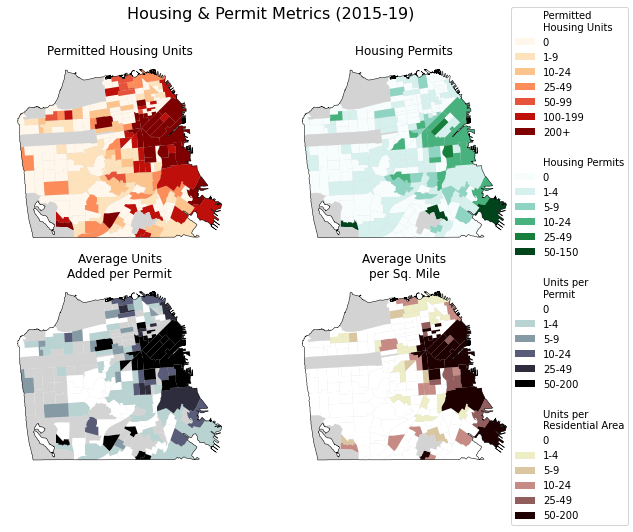

In [117]:
main_df['units.avg.15_19'] = main_df['units.tot.15_19'] / main_df['permits.tot.15_19']
main_df['units_p_area.avg.15_19'] = main_df['units.tot.15_19'] / main_df['res_area']

focus_gdf = main_df
focus_cols = [
    'units.tot.15_19',
 'permits.tot.15_19',
 'units.avg.15_19',
 'units_p_area.avg.15_19'
]
focus_gdf = focus_gdf[focus_cols+['geometry']].copy()
focus_labels = [
    "Permitted Housing Units",
    "Housing Permits",
    "Average Units\nAdded per Permit",
    "Average Units\nper Sq. Mile"
]
plot_title = 'Housing & Permit Metrics (2015-19)'

focus_styles = [0,1,2,3]

bin_dicts = {
    0:[0,1,5,10,25,50, 200, 1000],
    1:[0,1,5,10,25,50, 200],
    2:[0,1,5,10,25,50, 200],
    3:[0,1,5,10,25,50, 200]

}
label_dicts = {
    0:['0','1-9','10-24','25-49', '50-99', '100-199', '200+'],
    1:['0','1-4', '5-9','10-24','25-49', '50-150'],
    2:['0','1-4', '5-9','10-24','25-49', '50-200'],
    3:['0','1-4', '5-9','10-24','25-49', '50-200']
}
cmap_dicts = {
    0:'OrRd', 
    1:'BuGn',
    2:'bone_r',
    3:'pink_r'
}
legend_labels = {
    0:'Permitted\nHousing Units',
    1:'Housing Permits',
    2:'Units per\nPermit',
    3:'Units per\nResidential Area'
}
cmap_dicts = {
    style_index:
        get_cmap(label_dicts[style_index], cmap, grey_bottom=False) if any(lab for lab in label_dicts[style_index] if '%' in lab)
        else get_cmap(label_dicts[style_index], cmap, grey_bottom=False)
    for style_index,cmap in cmap_dicts.items()
}

### plotting

nrows, ncols = (int(len(focus_styles)/2), 2)
fig, ax = plt.subplots(int(nrows),int(ncols))
axes = []
[[axes.append([row, col]) for col in range(ncols)] for row in range(nrows)]

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], bins, labels=labels, include_lowest=True)

def bin_col(focus_df, focus_col, data_bins, data_labels):
    pot_max = max(focus_df[focus_col])
    if pot_max > data_bins[-1]:
        data_bins = data_bins[:-1] + [max(focus_df[focus_col])]
    return get_bins(focus_df, focus_col, data_bins, data_labels)

for e, focus_col in enumerate(focus_cols):
    row,col = axes[e]
    axis = ax[row,col]

    style_index = focus_styles[e]
    focus_col, focus_title = focus_cols[e], focus_labels[e]

    data_bin, data_label = bin_dicts[style_index], label_dicts[style_index]
    cmap = cmap_dicts[style_index]
    focus_gdf['bin_col'] = bin_col(focus_gdf, focus_col, data_bin, data_label)
    
    for value,color in cmap.items():
        temp_gdf = focus_gdf[focus_gdf['bin_col']==value]
        if len(temp_gdf) > 0:
            temp_gdf.plot(
                ax=axis,
                zorder=5, legend=True,
                color = color
            )
    sfblock.plot(
                ax=axis, zorder=4,
                color='lightgrey'
                )
    #plot_quads(ax)
    sf_landform_nonres.plot(ax=axis, color='lightgrey', zorder=8)
    sf_landform.plot(ax=axis, color='None', ec='black', lw=.5, zorder=9)
    axis.set_title(focus_title)
    axis.set_axis_off()

import matplotlib.patches as mpatches
handles = []
labels = []
for e,style_index in enumerate(set(focus_styles)):
    cmap = cmap_dicts[style_index]
    labs = [legend_labels[style_index]] + list(cmap.keys())
    colors = ['#FFFFFF'] + list(cmap.values())
    if (len(set(focus_styles)) > 1)&(e!=len(set(focus_styles))-1):
        colors = colors + ['#FFFFFF']
        labs = labs + ['    ']
    labels.extend(labs)
    handles.extend([mpatches.Patch(facecolor=color) for color in colors]) #mpatches.Patch(facecolor='r', edgecolor='#000000')

fig.legend(handles = handles, labels=labels,
        loc="center right", 
        #title="Approved Building\nPermits"
        #borderaxespad=0.1
        )
plt.subplots_adjust(right=0.85)
fig.suptitle(plot_title, fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)

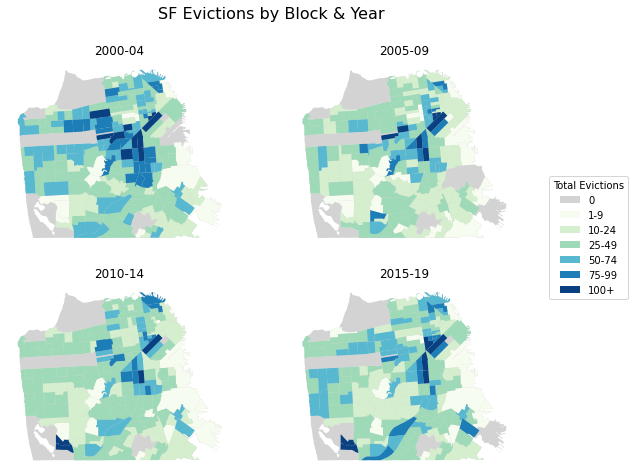

In [74]:
import matplotlib.pyplot as plt

nrows, ncols = (2,2)
fig, axes = plt.subplots(nrows,ncols)

date_col = '5years'
sfbb = sfevict.join(sfblock.set_index(['block_id', 'geoid10'])).reset_index()
sfbb = gpd.GeoDataFrame(sfbb)

focus_col = 'unit_bins'
date_col = '5years'

def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='tot_evictions'
data_bins = [0,1,10,25,50,75,100,max(sfbb[focus_col])]
data_labels = ['0','1-9','10-24','25-49', '50-74', '75-99', '100+']
sfbb['tot_evictions'] = get_bins(sfbb, focus_col, data_bins, data_labels)

cmap = get_cmap(data_labels, 'GnBu')

focus_col = 'tot_evictions'

year_bins = list(sfb_full[date_col].unique())
year_bins.sort()
year_bins = np.array(year_bins).reshape(nrows, ncols)

for row in range(nrows):
    for col in range(ncols):
        year = year_bins[row,col]
        ax = axes[row,col]
        sfbb_sub = sfbb[
            (sfbb[date_col]==year)#&(sfbb[focus_col]!=0)
        ]
        for value,color in cmap.items():
            sfbb_sub[sfbb_sub[focus_col]==value].plot(
                ax=ax,
                zorder=5,
                color = color
            )
        sfblock.plot(
            ax=ax, zorder=4,
            color='lightgrey'
            )
        #plot_quads(ax)

        ax.set_title('20'+str(year))
        ax.set_axis_off()

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
fig.legend(handles = handles, labels=labels,
       loc="center right", 
       title="Total Evictions"
       #borderaxespad=0.1
       )
plt.subplots_adjust(right=0.85)

fig.suptitle('SF Evictions by Block & Year', fontsize=16)
fig.set_size_inches(10, 7.5, forward=True)
#fig.tight_layout()

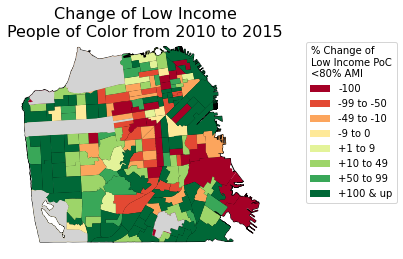

In [75]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='poc_linc.pct.10_15'
data_bins = [min(sfdemo[focus_col]), -100, -50, -10, 0, 10, 50, 100, max(sfdemo[focus_col])]
data_labels = ['-100','-99 to -50','-49 to -10', '-9 to 0', '+1 to 9', '+10 to 49', '+50 to 99', '+100 & up']
sfdemo['binned'] = get_bins(sfdemo, focus_col, data_bins, data_labels)
focus_col = 'binned'

def get_cmap(data_list, cmap, grey_bottom=True):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce += 1
    cmap = get_colors(len(data_labels)-reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    return {v:c for v,c  in zip(data_labels, cmap)}
cmap = get_cmap(data_labels, 'RdYlGn', grey_bottom=False)

ax = sfblock.plot(zorder=4, color='None')

for value,color in cmap.items():
    sfdemo[sfdemo[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       title="% Change of\nLow Income PoC\n<80% AMI",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Change of Low Income\nPeople of Color from 2010 to 2015', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

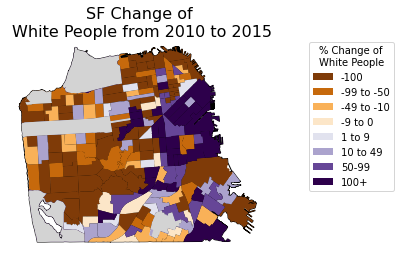

In [76]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_col='wht.pct.10_15'
data_bins = [min(sfdemo[focus_col]), -100, -50, -10, 0, 10, 50, 100, max(sfdemo[focus_col])]
data_labels = ['-100','-99 to -50','-49 to -10', '-9 to 0', '1 to 9', '10 to 49', '50-99', '100+']
sfdemo['binned'] = get_bins(sfdemo, focus_col, data_bins, data_labels)
focus_col = 'binned'
sfdemo = gpd.overlay(sfdemo, sf_landform, how='intersection')

def get_cmap(data_list, cmap, grey_bottom=True):
    def get_colors(n, cmap):
        from mycolorpy import colorlist as mcp
        color1=mcp.gen_color(cmap=cmap,n=n)
        return color1
    reduce = 0
    if grey_bottom == True:
        light_grey = '#D3D3D3'
        reduce += 1
    cmap = get_colors(len(data_labels)-reduce, cmap)
    if grey_bottom == True:
        cmap = [light_grey] + cmap
    return {v:c for v,c  in zip(data_labels, cmap)}
cmap = get_cmap(data_labels, 'PuOr', grey_bottom=False)

ax = sf_blockgroup.plot(zorder=4, color='None')

for value,color in cmap.items():
    sfdemo[sfdemo[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="% Change of\nWhite People",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('SF Change of \nWhite People from 2010 to 2015', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

In [77]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = gpd.GeoDataFrame(sfpar_g.join(sf_blockgroup.set_index('geoid10')))

focus_col='FAR.avg.2019'
data_bins = [0, .5, 1, 1.5, 2, 4, max(focus_gdf[focus_col])]
data_labels = ['0 to .4', '.5 to .9', '1 to 1.4', '1.5 to 1.9', '2 to 3.9', '4 to 10']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'hot_r', grey_bottom=False, skip_1=True)

ax = sf_blockgroup.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Average FAR\n(Bldg SqFt / Lot Area)",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Average Floor Area Ratio\nby Census Tract (2019)', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

TypeError: get_cmap() got an unexpected keyword argument 'skip_1'

<AxesSubplot:>

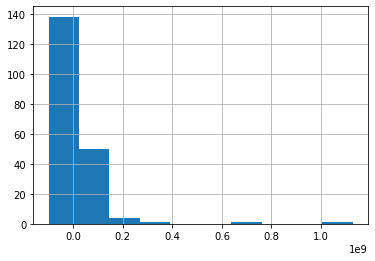

In [ ]:
sfdis['occ_ch.00_18'] = sfdis['occ_own_ch.pct.00_18'].astype(float) * 100
sfdis['occ_ch.00_18'].hist()

In [ ]:
max(focus_gdf[focus_col])

<AxesSubplot:>

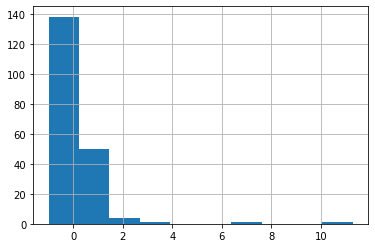

In [ ]:
focus_col= 'occ_own_ch.pct.00_18'
sfdis[
    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
]['occ_own_ch.pct.00_18'].hist()

In [ ]:
focus_col='occ_own_ch.pct.00_18'
min(focus_gdf[focus_col]*100)

-100.0

In [ ]:
sfdis[focus_col]

geoid10
06075015600   -8.951224e+18
06075010200    2.419670e+19
06075010800    6.291356e+18
06075033100   -6.779661e+18
06075040200    5.220704e+19
                   ...     
06075980200    4.982456e+19
06075980300   -1.000000e+20
06075980501   -7.332231e+19
06075980600   -7.880952e+18
06075980900   -7.384684e+19
Name: occ_own_ch.pct.00_18, Length: 195, dtype: float64

In [ ]:
def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = sfdis.copy()
focus_col='occ_own_ch.pct.00_18'
focus_gdf[focus_col] = focus_gdf[focus_col] * 100
#sfdis = sfdis[
#    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
#]

data_bins = [min(focus_gdf[focus_col]), -50, -10, 10, 50, max(focus_gdf[focus_col])]
data_labels = ['+50%','49 to 10%', '9 to -9%', '-10 to -49%', '-50%']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'seismic_r', grey_bottom=False)

ax = sf_blockgroup.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Change of Units\nthat are occupied\nby a renter",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Change in Renter Occupied Units\n2010-18', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

1128.972043010753

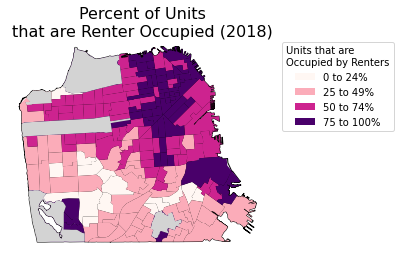

In [ ]:


def get_bins(focus_df, focus_col, bins, labels):
    return pd.cut(focus_df[focus_col], data_bins, labels=data_labels, include_lowest=True)

focus_gdf = sfdis.copy()
focus_col='occ_rent.pct.18'
#focus_gdf[focus_col] = focus_gdf[focus_col] * 100
#sfdis = sfdis[
#    (sfdis[focus_col]<1000)&(sfdis[focus_col]>-1000)
#]

data_bins = [0, 25, 50, 75, 100]
data_labels = ['0 to 24%', '25 to 49%', '50 to 74%', '75 to 100%']
focus_gdf['binned'] = get_bins(focus_gdf, focus_col, data_bins, data_labels)
focus_col = 'binned'
focus_gdf = gpd.overlay(focus_gdf, sf_landform, how='intersection')


cmap = get_cmap(data_labels, 'RdPu', grey_bottom=False)

ax = sf_blockgroup.plot(zorder=4, color='None')

for value,color in cmap.items():
    focus_gdf[focus_gdf[focus_col]==value].plot(
        ax=ax,
        zorder=5,
        color = color
    )

sf_landform_nonres.plot(ax=ax, color='lightgrey', zorder=8)

import matplotlib.patches as mpatches
labels = cmap.keys()
colors = cmap.values()
handles = [mpatches.Patch(facecolor=color) for color in colors] #mpatches.Patch(facecolor='r', edgecolor='#000000')
ax.legend(handles = handles, labels=labels,
       #loc="center right", 
       title="Units that are\nOccupied by Renters",
       bbox_to_anchor=(1.5,1)
       )
ax.set_axis_off()
plt.subplots_adjust(right=0.85)

fig = ax.get_figure()
fig.suptitle('Percent of Units\nthat are Renter Occupied (2018)', fontsize=16)
fig.set_size_inches(5, 4, forward=True)

In [ ]:
import seaborn

date_col = 'date_status'

sfb_plot = sfb[[date_col, 'units_prop', 'status', 'pid']]
sfb_plot[date_col] = sfb_plot[date_col].dt.to_period("Y").astype(str)

sfb_plot = sfb_plot.groupby([
    date_col, 'status'
    ]).agg({'units_prop':'sum', 'pid':'count'}).reset_index(drop=False)

seaborn.relplot(
    data=sfb_plot, 
    x=date_col, y='pid', hue='status', 
    aspect=1.61, kind="line"
    )


In [ ]:
approved_status = [
    'complete', 'issued',
    'filing', 'filed', 'disapproved', 'reinstated', 'appeal',
    'approved'
]

sfb.loc[sfb['status'].isin(approved_status)].plot()

## Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True

date_open = '2014Q3'
date_close = '2015Q3'

fig  = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)

def date_group(date_col, period = 'Q', group_df = sfp_all):
    return group_df.sort_values(date_col).groupby(group_df[date_col].dt.to_period(period))['id'].count()

date_col = 'date_open'
open_df = date_group(date_col)
open_df.plot(ax=ax, kind="line", label='Permits Opened')
#date_group(date_col, period="Y").plot(ax=ax, color='black', kind="bar")

date_col = 'date_close'
close_df = date_group(date_col)
close_df.plot(ax=ax, color='red', kind="line", label='Permits Closed')

ax.set_xlim(['2013Q3',None])
ax.set_ylim([0,None])

col = 'darkblue'
ax.vlines(
    x=date_open, ymin=0, ymax=max(open_df), colors=col, ls=':',
    label = 'Open Date Cutoff')
#ax.hlines(y=max(open_df), xmin=date_open, xmax=max(open_df.index), colors=col, ls=':')

col = 'maroon'
ax.vlines(
    x=date_close, ymin=0, ymax=max(close_df), colors=col, ls=':',
    label = 'Close Date Cutoff'
    )
#ax.hlines(y=max(close_df), xmin=date_close, xmax=max(close_df.index), colors=col, ls=':')

ax.set_xlabel('Quarters')
ax.set_ylabel('Count of Permits')
ax.legend(loc='best')

plt.show()

In [ ]:
#sfp[sfp['date_open']>='2015-01-01'].count()
#sfp[sfp['date_open']<'2015-01-01'].count()

sfp['date_openclose'] = sfp['date_open'].astype(str) + sfp['date_close'].astype(str)

sfp['length'] = (sfp['date_close'] - sfp['date_open']).dt.days
#(sfp['length']/365).hist()

long_plot = sfp.dropna(subset=['date_open','date_close'])

#fig  = plt.figure(figsize = (8,6))
#ax = fig.add_subplot(111)

period = 'Q'
#ax.barh(
#    long_plot.date_open.dt.to_period(period), 
#    long_plot.date_close.dt.to_period(period), 
#    left=long_plot.date_open.dt.to_period(period))


In [ ]:
a = sfp['date_app_acc'].dropna().count()
t = len(sfp)

a/t

unit_max = 100000
sjp_join = sfp[sfp['#units_prop']<unit_max].copy()

sfp_nhood = sjp_join.groupby('nhood')['id'].count().to_dict()
sfnhood['permit_count'] = sfnhood['nhood'].map(sfp_nhood).fillna(value=0).astype(int)


sfp_unit = sjp_join.groupby('nhood')['#units_prop'].sum().to_dict()
sfnhood['unit_prop_count'] = sfnhood['nhood'].map(sfp_unit).fillna(value=0)

sjp_join['unit_per_permit'] = sjp_join['#units_prop']/1
sfp_upp = sjp_join.groupby('nhood')['unit_per_permit'].median().to_dict()
sfnhood['unit_per_permit'] = sfnhood['nhood'].map(sfp_upp).fillna(value=0)

In [ ]:
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})

def set_label(
    bins,
    zero = True,
    binder = '-'
    ):
    binder = ' {} '.format(binder)

    if zero == True:
        bins = [0] + bins

    bins = list(zip(bins[:-1],bins[1:]))

    def to_string(pair):
        paired = str(pair[0]) + binder + str(pair[1])
        return paired

    bins = [to_string(bin) for bin in bins]
    bins = [
        '0' if bin == '0' + binder + '0'
        else bin 
        for bin in bins
        ]
    return bins

def set_legend(leg, new_texts, location=2):
    
    leg._loc = location

    for lbl,new_text in zip(leg.get_texts(), new_texts):
        label_text = lbl.get_text()
        #lower = label_text.split()[0]
        #upper = label_text.split()[2]
        #new_text = f'{float(lower):,.0f} - {float(upper):,.0f}'
        lbl.set_text(new_text)

In [ ]:
plot_col = 'permit_count'

map_bin = dict(bins=[0,50,100,200,300,400, sfnhood[plot_col].max()])

ax = sfnhood.plot(
    column=plot_col, 
    cmap='YlGn', 
    figsize=(40, 10), 
    scheme='User_Defined',
    classification_kwds=map_bin, k=len(map_bin)-1, 
    legend=True, linewidth=0.75, edgecolor='grey')

sfquads = zip(sfquad.geometry.centroid.x, sfquad.geometry.centroid.y, sfquad.quad)
for x, y, label in sfquads:
    ax.annotate(
        label, xy=(x, y), xytext=(3, 3), 
        textcoords="offset points",
        fontsize='large',
        fontweight='bold'
        )

leg = ax.get_legend()
set_legend(leg, set_label(map_bin['bins']))

,shape_area,objectid_1,objectid,globalid,quad,id,shape_len,geometry
0,362268282.883,4,641,{F27C8EDD-E046-4CD1-9071-8159E6102624},SE,0,227055.35836,"MULTIPOLYGON (((172787.480 91144.234, 172882.1..."
1,89271860.5954,3,642,{B4EECB96-F331-4B1B-99BC-E2AB05E2B09B},NE,0,99030.8515062,"MULTIPOLYGON (((166171.388 101163.671, 166226...."
2,338207863.134,1,643,{1B40529A-8F68-472A-9DB0-7C07C9C8DE0A},NW,0,116095.118353,"MULTIPOLYGON (((149466.332 100933.563, 149486...."
3,498989359.983,2,644,{7C611B7F-5452-4456-9100-60B437F86B72},SW,0,114854.453545,"MULTIPOLYGON (((164827.702 85927.360, 164846.9..."


In [ ]:
from matplotlib.text import Text
from matplotlib.legend import Legend

handles = list(string.ascii_uppercase)[:N] 
labels = [f"Model Name {c}" for c in handles]

fig, ax = plt.subplots()
ax.scatter(x, y, s=100, c=colors, alpha=0.5)
for i, xy in enumerate(zip(x, y)):
    ax.annotate(handles[i], xy=xy)

ax.legend(handles=handles, labels=labels)

In [ ]:
sfp.sort_values('#units_prop', ascending=False).head(30)

In [ ]:
path = r'static_data\sf_permit_acronyms.xlsx'
sfp_acr = pd.read_excel(path)
sfp_acr = {
    acr:name for acr,name in sfp_acr.set_index('Acronym')['Name'].to_dict().items()
    if type(acr) == str
}